**Comparison of longest common subsequence (LCS) algorithms**

**COT 6405 Analysis of Algorithms, Spring 2020**

**Christian Garbin**

# Introduction

This notebook compares **longest common subsequence** (defined below) algorithms:

- Brute-force: generates combinations of subseqences and check if they are common subsequences.
- Dynamic programming: takes advantage of common subproblems to not evaluate the same subsequence more than once.
- Hirschbger's linear space: a dynamic programming approach that uses significantly less space.

The comparison measures:

- Runtime efficiency: how long it take to find a longest common subsequence.
- Space efficiency: how much space is used to find a longest common subsequence.

The code used in the experiments is written in Pyhton 3.x.

# Longest common subsequence

Given a sequence $X = <x_1, x_2, \dots, x_m>$, another sequence $Z$ is a **subsequence** of $X$ if there is a strictly increasing sequence $<i_1, i_2, \dots, i_k>$ of indices of $X$ such that for all $j = 1, 2, \dots, k$, we have $x_{ij} = z_j$ \[CLRS01\].

For example:

- Given the sequence $X = <A, B, C, B, D, A, B>$
- The sequence $Z = <B, C, D, B>$ is a subsequence of $X$, with indices $<2, 3, 5, 7>$

Given two sequences, a **common subsequence** is a sequence that is common to both sequences. A **longest common subsequence** (LCS) is a maximum-length common subsequence.

For example:

- Given the sequences $X = <A, B, C, B, D, A, B>$ and $Y = <B, D, C, A, B, A>$
- The sequence $<B, C, A>$ is a common subsequence
- The sequence $<B, C, B, A>$ is a longest common subsequence
- The sequence $<B, D, A, B>$ is another LCS, therefore LCSs do not have to be unique

## Applications

Applications of LCS include determining if two organisms are similar by comparing their DNAs. In this case, "similar" can be determined by the longest common subsequence between the DNAs. The longer the subsequence, the more common the organisms are.

Building on the DNA example, LCS can be used as a form of compression. Using a pre-built suffix tree, an LCS-based solution compressed the human genome from about 3 GB to just over 8 MB \[BAF16\].

LCS is also used in version control systems to produce the "diff", the minimal amount of additions and deletions that transform the older version of a file into the new version, also known as the "edit distance" \[NAV01\]. For example, this output of Git's `diff` command between two versions of a file shows deletion and addition of two lines to transform the old version of the file into the new one:

````
@@ -33,15 +33,11 @@ class ModifiedFile(BaseCommit):
     '''Number of lines added to the file in this commit.'''
     deleted = Column(Integer)
-    '''Number of lines deleted from the file in tihs commit.'''
+    '''Number of lines deleted from the file in this commit.'''
-    commit_id = Column(String)
+    commit_id = Column(String, ForeignKey('commit_info.commit_id'))
````


# Notebook structure

The remainder of this notebook is structured as follows:

- **Algorithms**: describes the algorithms used in the tests.
- **Planning of experiments**: describes the experiments performed, data collected for each one, the analysis performed on them.
- **Initialization and verification**: initializes the notebook (import Python modules, set important environment values) and verifies that the algorithms are working before using them.
- **Measurement and analysis**: run the tests to collect the metrics and analyzes those metrics.
- **Code**: documents relevant pieces of the code and other technical aspects found during the development and execution of the tests.

# Algorithms

Three algorithms will be analyzed:

- Brute-force
- Dynamic programming
- Hirschberg’s linear space

In all sections below, $m$ is the lenght of the longest sequence and $n$ is the lenght of the shortest sequence.

## Brute-force

Brute-force is the simplest LCS algorithm is the brute-force approach: generate subsequences of the smaller sequence and check if they are also a subsequence of the larger sequence. 

The runtime is exponential, $O(2^n$), given that there are $2^n$ subsequences to try in the worst case scenario. Space usage depends the implementation. A naive implementation would generate all combinations of the smaller sequence ahead time, using $O(2^n)$ space. An optimized implementation generates one combination of the smaller sequence at a time, using $O(n)$ space.

The pseudocode for the algorithm is:

````
LCS_BRUTE_FORCE(X, Y)
    // Pick the shortest sequence to generate subsequences
    short_seq = shortest_of(X, Y)
    long_seq = longest_of(X, Y)

    // Try all subsequencesof the shortest sequence
    for i = length(short_seq) to 1
        // Try all subsequences of length i, one at a time
        while "there are subsequences of length i to try":
            subseq = next_subsequence(short_seq, i)
            if is_subsequence(subseq, long_seq)
                return subseq
    
    // Could not find a subsequence
    return [] // empty sequence
````

## Dynamic programming

Dynamic programming makes use of the optimal substructure of the LCS, solving smaller subproblems only once, combining the solutions. This algorithm has an $O(nm)$ running time. Its space is also $O(mn)$ \[CLRS01\].

The pseudocode is shown below. It has two parts: first two matrices are constructed to determine the LCS length and how to construct it (a series of "moves"), then the LCS is extracted by going through the moves matrix.

````
LCS_LENGTH(X, Y)
    m = length(X)
    n = length(Y)

    // c is an m x n matrix with the top row and
    // left column initialized to zero
    c = matrix(m, n)
    for i = 1 to m
        c[i, 0] = 0
    for j = 1 to n
        c[0, j] = 0

    // b is an m x n empty matrix that will hold the
    // movements to build the LCS
    b = matrix(m ,n)

    for i = 1 to m
        for j = 1 to n
            if X[i] == Y[j]
                c[i,j] = c[i-1,j-1] + 1
                b[i,j] =  "diagonal"
            else if c[i-1,j] >= c[i, j-1]
                c[i,j] = c[i-1,j]
                b[i,j] =  "up"
            else
                c[i,j] = c[i,j-1]
                b[i,j] =  "down"

    // c[m,n] has the LCS length and b has the
    // sequences of moves to extract the LCS
    return c, b

EXTRACT_LCS(b, X, i, j)
    lcs = empty_list()

    while i > 0 and j > 0
        move = b[i,j]
        if move == "diagonal"
            lcs = lcs + X[i]
            i = i - 1
            j = j - 1
        else if move == "up"
            i = i - 1
        else // "down"
            j = j - 1

    // The LCS was built from the bottom up,
    // need revert it before returning
    return reverse(lcs)

LCS(X, Y)
    b, c = LCS_LENGTH(X, Y)
    lcs = EXTRACT_LCS(b, X, length(X), length(Y))
    return lcs
````

## Hirschberg’s linear space

Hirschberg’s linear space algorithm \[HIR75\] is a dynamic programming approach that uses divide-and-conquer. As the name indicates, it makes efficient use of space. The running time is still $O(mn)$, but space is reduced to $O(m+n)$ \[KT05\] \[FAG16\].

The pseudocode is shown below. It has two parts: a "scoring" function to help decide where to divide the current subsequence being analyzed, and the function that divides-and-conquers, based on that score.

````
SCORE(X, Y)
    m = length(X)
    n = length(Y)

    // A list of of scores, initialized with n zeros
    scores = list(0 * n)

    for i = 1 to m
        prev_score = scores
        for j = 1 to n
            if X[i] == Y[j]
                scores[j+1] = prev_scores[j] + 1
            else
                scores[j+1] = max(scores[j], prev_scores[j + 1])
    
    return scores

LCS(X, Y)
    m = length(X)
    n = length(Y)
    if m == 0
        // Got to the end of the sequence
        return []
    else if m == 1
        // Last character, check if it is in subsequence
        if X[1] is in Y
            return X[1]
        else
            return []
    else
        // Find where to split the current sequences

        // X is split in the middle
        i = m / 2
        XB = X[i:i]
        XE = X[i+1:m]

        // Y is split based on the scores
        cost_top_left = SCORE(XB, Y)
        cost_bottom_right = SCORE(reverse(XE), reverse(Y)))
        cost = cost_top_left + reverse(cost_bottom_right)

        k = index of max(cost) // argmax(cost)
        YB = Y[1:k]
        YE = Y[k+1:n]

        // Solve for each part of the split sequences
        return LCS(XB, YB) + LCS(XE, YE)
````

# Planning of experiments

The experiments compare the runtime and space of the brute-force, dynamic programming recursive, and Hirchberg's linear space algorithms.

To illustrate the algorithms in a typical application, the tests will use two strings that resemble DNA sequences (a combination of the letters A, C, G, and T) and will find an LCS for them. To emulate the computational biology case of searching for a common substring between two DNA strands, in each case we will search for a string that is one-tenth of the larger strings, illustrated in the table below.

## Input size for tests

Strings of three sizes will be used, small, medium, large. For each size, the same strings will be used with all algorithms, to keep the comparison consistent.

| Test size |  The DNA strain (X)<br>This is the _m_ in RT and space analysis | The possible common sequence (Y)<br>This is the _n_ in RT and memory analysis |
|-|-:|-:|
| Small  |   1,000 |   100  |
| Medium |  10,000 |  1,000 |
| Large  | 100,000 | 10,000 |
Table 1 - Size of strings to test and how they map to the m and n of the RT and memory analysis.

## Runs

Each algorithm will be executed ten times (k=10) for each string size to remove variations in the environment. The average of these runs will be used as the final number for the algorithm.

Two values will be measured in each run, running time (RT) and memory (space) usage:

- Time: measured with Python's [`time` package](https://docs.python.org/3/library/time.html).
- Memory: measured with Python's [`memory_profiler` package](https://pypi.org/project/memory-profiler/).

Details of how measurements were conducted are documented in the code section, later in this document.

## Data structures

Experimental data, the strings, will be stored in the standard data structures for string representation, usually mapped to a constant-time access continuous array in programming languages. Auxiliary data structures to keep track of intermediate results will be kept either in Pythnon arrays on NumPy arrays, whichever is more performant for a specific piece of code.

## Input generation

Strings for the tests will be generated using a pseudo-random number generation initialized with a seed, to ensure the repeatability of the experiments (the same sequence is generated every time). The strings will be generated only once, before each algorithm is executed, to ensure that the results can be compared with each other.

## Graphs and tables

For each algorithm, two tables will be filled in:

- RT analysis: theoretical vs. empirical RT.
- Memory usage: theoretical vs. empirical memory usage.

The following table illustrates the RT analysis for the brute-force algorithm.

| Test size | Theoretical complexity |  Empirical RT (ms) | Ratio (empirical RT / theoretical complexity | Predicted RT | % error |
|-|-|-|-|-|-|
| Small<br> m=1,000, n=100 | $2^n$ = $2^{100}$ | | | | |
| Medium<br> m=10,000, n=1,000 | $2^n$ = $2^{1000}$ | | | | |
| Large<br> m=100,000, n=10,000 | $2^n$ = $2^{10000}$ | | | | |
Table 2 - RT analysis table example, using the brute-force algorithm as illustration

The table columns are computed as follows:

- _Ratio_ measures the ratio between the empirical and the theoretical complexity. Its value is always > 0. It is used to calculate the constant _c_.
    - The constant _c_ measures the overhead of the steps (computer instructions) that are outside the main loops (or recursive calls) of the algorithms. It is determined as the maximum of the ratio values (with outliers discarded), i.e. the maximum value of the _Ratio_ column.
- _Predicted RT_ is computed as the constant _c_ times the _Theoretical complexity_.
- _% error_ measures the discrepancy between the predicted and the empirical time: _(Empirical RT - Predicted RT) / Empirical RT * 100_.

The following table illustrates memory usage for the brute-force algorithm.

| Test size | Theoretical memory usage (KiB) | Empirical memory usage (KiB) | % error |
|-|-|-|-|
| Small<br>m=1,000, n=100 | n  / 1024 = 0.98 | |
| Medium<br>m=10,000, n=1,000 | 9.8 | |
| Large<br>m=100,000, n=10,000 | 97.7 | |
Table 3 - Memory usage analysis table example, using the brute-force algorithm as illustration

The table columns are computed as follows:

- _Theoretical memory usage_ is the number of characters needed, times 1 byte per character, divided by 1,024 to transform to KiB.
    - "1 byte per character" comes from the variable-length encoding of strings in Python using the CPython environment. Because we are representing DNA strands, we are using only ASCII characters, which are represented as 1 byte \[CPY20\] \[GOL20\].
- _% error_ measures the discrepancy between the theoretical and empirical memory usage: _Empirical memory usage / Predicted memory usage) / Empirical memory usage * 100_.

For the other algorithms, the theoretical values will be adjusted as follows:

- Dynamic programming:
    - Theoretical RT = $m \times n$
    - Theoretical memory usage = $m \times n$
- Hirschberg’s linear space algorithm
    - Theoretical RT = $m \times n$
    - Theoretical memory usage = $m + n$

Once the tables are filled in, two sets of graphs will be created:

- **Algorithm comparison**: this set of graphs compares the empirical runtime and memory usage of the algorithms. There will be one runtime and one memory usage plot for all algorithms (two graphs).
- **Theoretical vs. empirical results**: this set of graphs compares the empirical runtime and memory usage of each algorithm. There will be one set of plots for each algorithm and each size, for a total of 9 graphs (3 algorithms, 3 sizes).

The following graphs will be generated for algorithm comparison:

- RT comparison: a horizontal bar graph with the runtime in ms (horizontal axis) for each algorithm, grouped by the input size. A horizontal bar graph will be used because of the expected large values for large input sizes. This representation makes better use of space.
- Memory comparison: similar to the graph above, using memory usage as the horizontal axis.

The following graphs will be generated for each algorithm for the theoretical vs. empirical results:

- Theoretical vs. empirical runtime in ms for each input size
- Theoretical vs. empirical memory usage in KiB for each input size

## Programming language

The experiments use Python 3.x in a Jupyter Notebook environment.

# Initialization and verification

Set a seed to make pseudo-random generator generate the same sequence across runs. This makes it easier to compare different runs of the algorithms.

In [1]:
import random
random.seed(42)

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('precision', 3)
# Set to True when converting to PDF
pd.set_option('display.latex.repr', False)

Check that the algorithms work by testing them against controlled input.

There are three part to the tests:

1. Automated tests that check against well-defined inputs. They are meant to be easy to debug, in case an algorithm fails.
1. Tests with longer inputs that simular DNA strands. They test more realistic scenarios, but still short enough to run fast.
1. A visual check, by printing the aligned subsequence. They guard against the test code itself having a failure that generates false positives.

In [3]:
import lcs_test

lcs_test.test(visualize=True)

All basic tests passed
All DNA tests passed
Visual inspection:
                         lcs_brute_force:  TACCGCATTATCGATACTTTTACCGACAAC
                         lcs_brute_force:  ....G.......G.T.CTTT.A...ACAA. size=12
    lcs_dynamic_programming_matrix_numpy:  ....G.......G.T.CTTT.A...ACAA. size=12
                    lcs_hirschberg_numpy:  ....G.......G.T.CTTT.A...ACAA. size=12


# Runtime tests and analysis

To illustrate a real-life scenario, the code checks if a DNA strand is part of
a larger DNA sequence \[[WIK20](https://en.wikipedia.org/wiki/Subsequence#Applicationshttps://en.wikipedia.org/wiki/Subsequence#Applications)\].

In [61]:
# Force reload because this piece of code frequently changes
import importlib
import metrics as m
importlib.reload(m);

## Constant _c_ calculation

This section calculates the constant _c_ for each algorithm. This is the constant that accounts for instructions that are not in the loops. For example, given a runtime $O(n^2)$, the constant _c_ allows us to write the runtime more precisely as $c \times n^2$. 

The constant is also affected by the language and compiler or intepreter used. In this notebook it is calculated with dynamic analysis: run the code and calculate the overhead.

Each algorithm was executed once with different input sizes, with the pairs representing the length of X and Y, respectively: (1,000, 100), (2,000, 200), (3,000, 300), (4,000, 300), (4,000, 500), (4,000, 1,000).

Once the algorithms are run, we calculate _c_ as $max (rt1, rt2, ...., rt_n)$, excluding outliers where applicable.

This dataframe has the test results for all algorithms. It will be filtered in the next sections to calculate each algorithm separately.

In [42]:
rt_results_raw, rt_results_summary = m.runtime(verbose=1, file='runtime-phase1')

Loading from file


We now how have two Pandas DataFramse:

- `rt_results_raw`: results from all 10 executions of each algorithms and each input size.
- `rt_results_summary`: average of the executions for each each algorithm and input size.

Using these DataFrames, the following sections calculate three constants, one for each algorithm. They are stored in the following variables:

- `c_bf`: the constant for the brute-force algorithm.
- `c_dp`: the constant for the dynamic programming algorithm.
- `c_h`: the constant for the Hirschberg linear space algorithm.

### Constant _c_ for brute-force

The table below shows a large error for the brute-force algorithm. This is likely caused by the small "vocabulary" used to create the sequences. 

DNA is represented by a combination of four letter, A, C, G, and T. With this small number of letters to combine, it is relatively easy to find subsequences in a sequence that is ten times larger.

> Add an experiment with full alphabet, small and capital letters, plus numbers.

In [62]:
rt_bf, c_bf = m.add_analysis(rt_results_summary, m.ALG_BRUTE_FORCE)
print('c_bf={}'.format(c_bf))
display(rt_bf)

c_bf=5.206481974415714e-32


,Algorithm,Sequence size,Subsequence size,Empirical RT (ms),Theoretical complexity,Ratio,Predicted RT,% error
0,Brute force,1000,100,0.066,1.268e+30,5.206e-32,6.600e-02,0.000e+00
1,Brute force,2000,200,0.173,1.607e+60,1.077e-61,8.366e+28,-4.836e+31
2,Brute force,3000,300,0.206,2.037e+90,1.011e-91,1.061e+59,-5.148e+61
3,Brute force,4000,300,0.256,2.037e+90,1.257e-91,1.061e+59,-4.143e+61
4,Brute force,4000,500,0.495,3.273e+150,1.512e-151,1.704e+119,-3.443e+121
5,Brute force,4000,1000,156.909,1.072e+301,1.464e-299,5.579e+269,-3.555e+269
6,Brute force,5000,900,0.601,8.453e+270,7.110e-272,4.401e+239,-7.323e+241
7,Brute force,5000,1000,0.658,1.072e+301,6.141e-302,5.579e+269,-8.478e+271
8,Brute force,5000,1200,0.760,inf,0.000e+00,inf,-inf


We can see in the table a very large error for most tests of the brute-force algorithm. This is caused by the "luck factor" of this algorithm: if we are lucky and generate a combination early on that happens to be a common subsequence, the algorithm terminates quickly. The probability of generating a common subsequence is high in this case because of the reduced amount of possible combinations we have when using only the four letter of a DNA sequence.

Given the "luck factor" of this case, analyzing the predicted vs. empirical runtime will not be insightful.

###  Constant _c_ for dynamic programming

In [63]:
rt_dp, c_dp = m.add_analysis(rt_results_summary, m.ALG_DYNAMIC_PROGRAMMING)
print('c_dp={}'.format(c_dp))
display(rt_dp)

c_dp=0.0001627695555555558


,Algorithm,Sequence size,Subsequence size,Empirical RT (ms),Theoretical complexity,Ratio,Predicted RT,% error
9,Dynamic programming,1000,100,15.257,100000,1.526e-04,16.277,-6.685
10,Dynamic programming,2000,200,62.163,400000,1.554e-04,65.108,-4.737
11,Dynamic programming,3000,300,142.757,900000,1.586e-04,146.493,-2.617
12,Dynamic programming,4000,300,182.718,1200000,1.523e-04,195.323,-6.899
13,Dynamic programming,4000,500,308.720,2000000,1.544e-04,325.539,-5.448
14,Dynamic programming,4000,1000,612.753,4000000,1.532e-04,651.078,-6.255
15,Dynamic programming,5000,900,732.463,4500000,1.628e-04,732.463,0.000
16,Dynamic programming,5000,1000,777.084,5000000,1.554e-04,813.848,-4.731
17,Dynamic programming,5000,1200,938.708,6000000,1.565e-04,976.617,-4.038


Since all results are within a small margin of error, none of them will be discarded for the calculation.

###  Constant _c_ for Hirschberg's linear space

In [64]:
rt_h, c_h = m.add_analysis(rt_results_summary, m.ALG_HIRSCHBERG)
print('c_h={}'.format(c_h))
display(rt_h)

c_h=0.00034574999999999363


,Algorithm,Sequence size,Subsequence size,Empirical RT (ms),Theoretical complexity,Ratio,Predicted RT,% error
18,Hirschberg,1000,100,34.575,100000,3.457e-04,34.575,0.000
19,Hirschberg,2000,200,135.058,400000,3.376e-04,138.300,-2.400
20,Hirschberg,3000,300,290.896,900000,3.232e-04,311.175,-6.971
21,Hirschberg,4000,300,387.301,1200000,3.228e-04,414.900,-7.126
22,Hirschberg,4000,500,621.257,2000000,3.106e-04,691.500,-11.307
23,Hirschberg,4000,1000,1226.753,4000000,3.067e-04,1383.000,-12.737
24,Hirschberg,5000,900,1399.517,4500000,3.110e-04,1555.875,-11.172
25,Hirschberg,5000,1000,1542.752,5000000,3.086e-04,1728.750,-12.056
26,Hirschberg,5000,1200,1846.447,6000000,3.077e-04,2074.500,-12.351


Some of the results are of by more than 10%, but not by much, so we will keep all of them for the calculation.

## Empirical vs. predicted RT graphs

The graphs below compare the empirica runtime with the predicted runtime. The predicted runtime is calcutated as _c_ $\times$ _theoretical complexity_.

### Dynamic programming

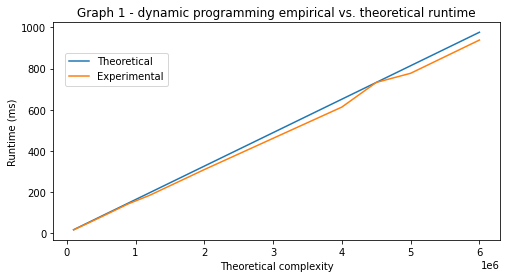

In [98]:
def plot_empirical_theoretical_rt(data, title):
    fig = plt.figure(figsize=(8,4))
    sns.lineplot(x=m.DF_THEORETICAL_COMPLEXITY, y=m.DF_PREDICTED_RT, data=data)
    ax = sns.lineplot(x=m.DF_THEORETICAL_COMPLEXITY, y=m.DF_EMPIRICAL_RT, data=data)
    plt.title(title)
    plt.ylabel("Runtime (ms)")
    fig.legend(['Theoretical', 'Experimental'], bbox_to_anchor=(0.3, 0.8))
    plt.show()

plot_empirical_theoretical_rt(rt_dp, 
    "Graph 1 - dynamic programming empirical vs. theoretical runtime")

### Hierschberg's linear space

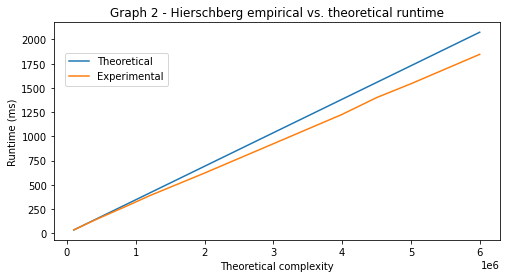

In [100]:
plot_empirical_theoretical_rt(rt_h, 
    "Graph 2 - Hierschberg empirical vs. theoretical runtime")

### Space usage and analysis

In [9]:
mem_results_raw, mem_results_summary = m.memory(verbose=1, file='memory')

Loading from file


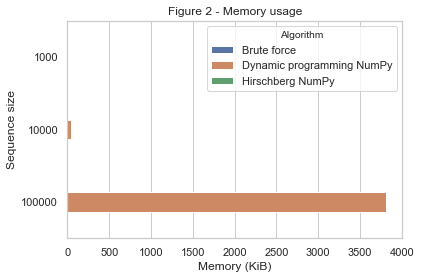

In [16]:
sns.barplot(data=mem_results_summary, y=m.DF_SEQ_SIZE,
            x=m.DF_MEMORY, hue=m.DF_ALGORITHM,
            orient='h').set_title('Figure 2 - Memory usage');

## Code structure and description

> Describe structure of the code

### How time was measured

### How memory was measured

### Code optimizations


## References

\[BAF16\] Beal, R., Afrin, T., Farheen, A. et al. 2016. _A new algorithm for “the LCS problem” with application in compressing genome resequencing data_. BMC Genomics 17, 544 (2016). https://doi.org/10.1186/s12864-016-2793-0, accessed 2020-03-16.

\[CLRS01\] Cormen, T., Leiserson, C., Rivest, R., and Stein, C. 2001. *Introduction to Algorithms*, 2<sup>nd</sup> edition. MIT Press.

\[CPY20\] _The CPython source code_. https://github.com/python/cpython/blob/v3.6.3/Include/unicodeobject.h#L202, accessed 2020-03-18.

\[GOL20\] Golubin, A. _How Python saves memory when storing strings_. https://rushter.com/blog/python-strings-and-memory/, accessed 2020-03-18.

\[HIR75\] Hirschberg, D. _A linear space algorithm for computing maximal common subsequences._ Commun. ACM 18 (1975): 341-343.

\[KT05\] Kleinberg, J. and Tardos, E. 2005. _Algorithm Design_. Addison-Wesley Longman Publishing Co., Inc., USA.

\[NAV01\] Navarro, G. 2001. _A guided tour to approximate string matching_. ACM Computing Surveys. http://users.csc.calpoly.edu/~dekhtyar/570-Fall2011/papers/navarro-approximate.pdf, accessed 2020-03-27.

\[FAG16\] Fagerberg, R. 2016. _Dynamic Programming: Hirschberg’s Trick_. https://imada.sdu.dk/~rolf/Edu/DM823/E16/Hirschberg.pdf, accessed 2020-04-25.

\[WIK20\] Wikipedia, _Subsequence_ entry, _Applications_ section, https://en.wikipedia.org/wiki/Subsequence#Applications, accessed 2020-03-18.

References used in the code are annotated directly in the code.

## Appendix

> Show full data from the experiments here